# Solving the Hamiltonian in different Ways



## Generating an XXZ Hamiltonian

### What is the XXZ Hamiltonian?

We first must generate some XXZ Hamiltonian. This describes the total energy of all of the 'spin-arrows'. 

- The XX part describes the tendency of neighbouring spins to align in the horizontal (x) and vertical (y) directions. This interaction is isotropic.
- THE Z part describes the interaction strength between spins in the "up/down" (z) direction.

The whole Hamiltonian is

$$H = J \sum_{i=1}^{L-1} (S_i^xS^x_{i+1} + S^y_iS^y_{i+1} + \Delta S^z_i S^z_{i+1})$$

- $J$ is the **coupling constant**. If $J>0$ then neighbouring spins like to point in opposite directions (antiferromagnetic). If $J<0$ then neighbouring spins like to point in the same direction (ferromagnetic). 
- The sum means that we sum over all adjacent pairs of sites, from site 1 and 2, up to site $L-1$ and $L$. This describes an "open chain". 
- $S^x_i$ is the component of spin in the $x$-direction at site $i$, and so on.
- $\Delta$ is the **anisotropy parameter**, which tunes the strength of the $z$ interaction.

For a spin-1/2 system, the spin operators are represented by the Pauli matrices i.e.

$$S^x = \frac{1}{2} \begin{pmatrix}0 & 1 \\ 1 & 0 \end{pmatrix}, \quad S^y = \frac{1}{2} \begin{pmatrix}0 & -i \\ i & 0 \end{pmatrix}, \quad S^z = \frac{1}{2} \begin{pmatrix}1 & 0 \\ 0 & 1 \end{pmatrix}$$

### Building the full Hamiltonian

The real challenge is constructing the Hamiltonian for $L$ spins - the total system size is $2^L \times 2^L$ which grows fast with $L$. 

To get an operator that acts only on site $i$, we need the tensor product. For example, the operator $S^z_i$ for a 3-spin ($L=3$) chain is 

$$S^z_1 = S^z \otimes I \otimes I, \quad S^z_2 = I \otimes S^z \otimes I, \quad S^z_3 = I \otimes I \otimes S^z \\$$

In [1]:
using LinearAlgebra

function get_xxz_hamiltonian_exact(L::Int, J::Float64, Δ::Float64)
    """
    Constructs the Hamiltonian for the XXZ spin chain model with L sites, coupling constant J, and anisotropy parameter Δ.
    """
    dim = 2^L

    # define the pauli matrices we need
    sx = 0.5 * [0.0 1.0; 1.0 0.0] # pauli X
    sy = 0.5 * [0.0 -im; im 0.0] # pauli Y
    sz = 0.5 * [1.0 0.0; 0.0 -1.0] # pauli Z
    id = I(2) # 2D identity from LinearAlgebra

    # init as a zero matrix
    H = zeros(ComplexF64, dim, dim)

    # now we can construct the hamiltonian (i.e. fill it with the right values)
    # loop over all the sites 0 to L-1
    for i in 1:L-1
        j = i + 1 # j is the adjacent site to i (to the right)

        # we need to construct the full terms for each interaction
        term_xx = 1.0
        term_yy = 1.0
        term_zz = 1.0

        for site in 1:L
            if site == i
                # if we are on the ith site, we want to add the sx, sy, sz terms
                term_xx = kron(term_xx, sx)
                term_yy = kron(term_yy, sy)
                term_zz = kron(term_zz, sz)
            elseif site == j 
                # if we are on the jth site, we want to add the sx, sy, sz terms
                term_xx = kron(term_xx, sx)
                term_yy = kron(term_yy, sy)
                term_zz = kron(term_zz, sz)
            else
                # otherwise we add the identity
                term_xx = kron(term_xx, id)
                term_yy = kron(term_yy, id)
                term_zz = kron(term_zz, id)
            end
        end

        # now we can add these terms to the hamiltonian
        H += J * term_xx + J * term_yy + J * Δ * term_zz
    end

    return H
end


get_xxz_hamiltonian_exact (generic function with 1 method)

#### Note - what does `kron` do?
`kron(a,b)` computes the Kroenecker product of two vectors/matrices/numbers. 

In [2]:
function solve_xxz_hamiltonian_exact(H)
    eigens = eigen(Hermitian(H))
    eigenvalues = eigens.values
    ground_state = minimum(eigenvalues)
    ψ = eigens.vectors[:, argmin(eigenvalues)]
    return eigens, ground_state, ψ
end

N = 2
J = 1.0
Δ = 1.5

h = get_xxz_hamiltonian_exact(N, J, Δ)
exact_eigens, exact_ground_state, ψ_chain_exact = solve_xxz_hamiltonian_exact(h)

println("Exact Hamiltonian:")
println(real(h))
println("\n")
println("Eigenvalues:\n$(exact_eigens.values)\n")
println("Ground state energy: $exact_ground_state\n")
println("Ground state wavefunction:\n$(real(ψ_chain_exact))\n")

Exact Hamiltonian:
[0.375 0.0 0.0 0.0; 0.0 -0.375 0.5 0.0; 0.0 0.5 -0.375 0.0; 0.0 0.0 0.0 0.375]


Eigenvalues:
[-0.8749999999999994, 0.125, 0.375, 0.375]

Ground state energy: -0.8749999999999994

Ground state wavefunction:
[0.0, 0.7071067811865477, -0.7071067811865475, 0.0]



### Issues with this

This is very slow... For $L=100$, the number of states is larger than the number of atoms in the universe, which cannot be stored on any computer.

## Density Matrix Renormalization Group (DMRG)

The core idea behind DMRG is to focus only on what's important, and forget everything else. But what does imporatant actually mean?

We use a **density matrix**, which tells us how strongly one part of the system is entangled with another. By analysing the density matrix, DMRG can make a very intelligent decision about which states to discard. 

In [3]:
# first we need a function to generate a MPS representation of the ground state
using ITensors 
using ITensorMPS

function create_MPS(L::Int, Χ::Int; conserve_qns::Bool=true)
    """Create a random MPS for a spin-1/2 chain of length L with bond dimension Χ."""
    # create a site set for a spin-1/2 chain
    sites = siteinds("S=1/2", L; conserve_qns=conserve_qns) # conserve total Sz

    # create a random MPS with bond dimension Χ
    init_state = [isodd(i) ? "Up" : "Dn" for i = 1:L] # antiferromagnetic ground state
    # THIS IS IMPORTANT - SEE NOTE BELOW
    # it sets the subspace of states we are allowed to explore
    # for example, this init_state means we only explore states with total Sz = 0 (i.e. zero magnetisation)
    # this is a reasonable assumption for positive J, but not for negative J
    # if we want to explore ferromagnetic states (negative J), we would need a different init_state
    ψ0 = randomMPS(sites, init_state)
    return ψ0, sites
end

create_MPS (generic function with 1 method)

In [4]:
using LightGraphs
using Graphs, GraphPlot

function generate_adjacency_matrix(L::Int, p::Float64)
    """
    Generate the adjacency matrix for a 1D chain of length L, where each node is connected to every other with probability p.
    """
    G = LightGraphs.erdos_renyi(L, p) # start with no edges
    return LightGraphs.adjacency_matrix(G)
end

function plot_adjacency_matrix(adj_mat; layout_type::String = "circular")
    """
    Plot the graph represented by the adjacency matrix.

    layout_type can be "circular", "spring", "spectral", or "random".
    """

    layout_lookup = Dict("circular" => circular_layout,
                         "spring" => spring_layout,
                         "spectral" => spectral_layout,
                         "random" => random_layout)

    G = Graphs.SimpleGraph(adj_mat)
    N = size(adj_mat, 1)

    node_labels = [string(i) for i in 1:N]

    p = GraphPlot.gplot(
        G, 
        layout=layout_lookup[layout_type],
        nodelabel=node_labels,
        nodesize=0.3,
        nodelabelsize=3,
        edgelinewidth=2.0,
    ) # plot the graph with the specified layout
    display(p)
    return p
end

plot_adjacency_matrix (generic function with 1 method)

In [5]:
#! Get's error Flux Size doesn't match (or something)
function get_xxz_hamiltonian_itensor(sites, adj_mat, J::Float64, Δ::Float64)
    """
    Constructs the Hamiltonian for the XXZ spin chain model using ITensors, given a site set and an adjacency matrix.
    """
    L = length(sites)
    
    terms = ITensor[]

    for j in 1:L-1
        if adj_mat[j, j+1] == 1
            sj_x = op("Sx", sites, j)
            sjp1_x = op("Sx", sites, j+1)
            push!(terms, J * sj_x * sjp1_x)
            sj_y = op("Sy", sites, j)
            sjp1_y = op("Sy", sites, j+1)
            push!(terms, J * sj_y * sjp1_y)
            sj_z = op("Sz", sites, j)
            sjp1_z = op("Sz", sites, j+1)
            push!(terms, Δ * sj_z * sjp1_z)
        end
    end 
    H = sum(terms)
    return H
end

get_xxz_hamiltonian_itensor (generic function with 1 method)

We have 

$$S^+S^- + S^-S^+ = 2(S^x_iS^x_{i+1}+S^y_iS^y_{i+1})$$

In [6]:
# from ASH - XXZ Hamiltonian as an MPO. Not sure why mine didn't work in comparison to this
function create_xxz_hamiltonian_mpo(N, adj_mat, J, Δ, sites)
    ampo = OpSum()
    for i = 1:N-1
        for j = i+1:N
            if adj_mat[i, j] == 1  # if there is some entanglement between i and j
                # XX and YY terms: S+S- + S-S+ = 2(SxSx + SySy)
                # So to get J(SxSx + SySy), we need J/2 * (S+S- + S-S+)
                ampo += J/2, "S+", i, "S-", j
                ampo += J/2, "S-", i, "S+", j
                # ZZ term
                ampo += J*Δ, "Sz", i, "Sz", j
            end
        end
    end
    H = MPO(ampo, sites)
    return H
end

create_xxz_hamiltonian_mpo (generic function with 1 method)

In [7]:
function solve_xxz_hamiltonian_dmrg(H, ψ0, sweeps::Int=10, bond_dim::Int=1000, cutoff::Float64=1E-14)
    """Solves the XXZ Hamiltonian using DMRG with given parameters. Returns the ground state energy and MPS. """
    swps = Sweeps(sweeps)
    setmaxdim!(swps, bond_dim)
    setcutoff!(swps, cutoff)
    E, ψ = dmrg(H, ψ0, swps; outputlevel=0)
    return E, ψ # only ground state and ground state wavefunction
end

solve_xxz_hamiltonian_dmrg (generic function with 4 methods)

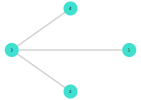

Ground state energy from DMRG: -1.375


In [8]:
# parameters
N = 4 # length of the spin chain i.e. number of nodes
Χ = 100 # bond dimension
J = 1.0 # coupling constant
Δ = 1.5 # anisotropy parameter
p = 0.5 # probability of entanglement
sweeps = 10 # number of DMRG sweeps


ψ0, sites = create_MPS(N, Χ)
adj_mat = generate_adjacency_matrix(N, p)
plot_adjacency_matrix(adj_mat; layout_type="circular")
H = create_xxz_hamiltonian_mpo(N, adj_mat, J, Δ, sites)
E, ψ = solve_xxz_hamiltonian_dmrg(H, ψ0, sweeps, Χ)
println("Ground state energy from DMRG: $E")

# How much faster is it? 

Should compare the results for the chain of atoms as the exact diagonalisation does.

In [9]:
function generate_chain_adjacency_matrix(N::Int)
    """
    Generate adjacency matrix for a 1D chain with N nodes and nearest-neighbor connections only.
    Returns a symmetric N×N matrix where adj_mat[i,j] = 1 if nodes i and j are connected.
    """
    adj_mat = zeros(Int, N, N)
    
    # connect each node to its nearest neighbors
    for i in 1:N-1
        adj_mat[i, i+1] = 1  # Connect i to i+1
        adj_mat[i+1, i] = 1  # Connect i+1 to i (make symmetric)
    end
    
    return adj_mat
end

generate_chain_adjacency_matrix (generic function with 1 method)

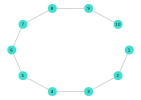


Ground state energy from DMRG (chain): -5.007453912006297
Time taken for DMRG (chain): 2.282133958 seconds

Ground state energy from exact diagonalisation: -5.0074539120062935
Time taken for exact diagonalisation: 0.311607208 seconds

Difference between DMRG and exact diagonalisation: -3.552713678800501e-15
Relative difference: 7.0948504793668e-16
DMRG is 0.1365420320343877 times faster than exact diagonalisation for N=10


In [10]:
# compare to original ground state - this is the case where we have a chain

N = 10
Χ = 100 # bond dimension
J = 1.0 # coupling constant
Δ = 1.5 # anisotropy parameter


adj_mat = generate_chain_adjacency_matrix(N)
plot_adjacency_matrix(adj_mat)
ψ0_chain, sites_chain = create_MPS(N, Χ)
H_chain = create_xxz_hamiltonian_mpo(N, adj_mat, J, Δ, sites_chain)
dmrg_time = @elapsed ground_state_dmrg, ψ_chain_dmrg = solve_xxz_hamiltonian_dmrg(H_chain, ψ0_chain, sweeps, Χ)
print("\n")
println("Ground state energy from DMRG (chain): $ground_state_dmrg")
println("Time taken for DMRG (chain): $dmrg_time seconds\n")

# compare to exact diagonalisation
h_chain = get_xxz_hamiltonian_exact(N, J, Δ)
exact_time = @elapsed eigens_chain_exact, ground_state_exact, ψ_chain_exact = solve_xxz_hamiltonian_exact(h_chain)
println("Ground state energy from exact diagonalisation: $ground_state_exact")
println("Time taken for exact diagonalisation: $exact_time seconds\n")

# Difference
println("Difference between DMRG and exact diagonalisation: $(ground_state_dmrg - ground_state_exact)")
println("Relative difference: $((ground_state_dmrg - ground_state_exact)/ground_state_exact)")
# It should be very small, on the order of 1E-10 or less

println("DMRG is $(exact_time/dmrg_time) times faster than exact diagonalisation for N=$N")


We can plot a graph of DMRG - EXACT ground state results as the bond dimension increases, to see how it affects accuracy.

[0.27607920837605826, 0.03959673369146368, 0.019789780146834118, 0.0015640003525200777, 0.0009514595386628219, 0.0003572078533658658, 0.0001808541998037508, 4.2417267873643235e-6, 3.055181138759301e-6, 1.8503450434844545e-6, 9.073294373219549e-7, 3.350858703640593e-7, 1.9499022309311062e-7, 5.549188543076823e-8, 2.8303345475070912e-8]


┌ Warning: No strict ticks found
└ @ PlotUtils /Users/jamesneville-rolfe/.julia/packages/PlotUtils/dVEMd/src/ticks.jl:194
┌ Warning: No strict ticks found
└ @ PlotUtils /Users/jamesneville-rolfe/.julia/packages/PlotUtils/dVEMd/src/ticks.jl:194
┌ Warning: No strict ticks found
└ @ PlotUtils /Users/jamesneville-rolfe/.julia/packages/PlotUtils/dVEMd/src/ticks.jl:194
┌ Warning: No strict ticks found
└ @ PlotUtils /Users/jamesneville-rolfe/.julia/packages/PlotUtils/dVEMd/src/ticks.jl:194
┌ Warning: No strict ticks found
└ @ PlotUtils /Users/jamesneville-rolfe/.julia/packages/PlotUtils/dVEMd/src/ticks.jl:194
┌ Warning: No strict ticks found
└ @ PlotUtils /Users/jamesneville-rolfe/.julia/packages/PlotUtils/dVEMd/src/ticks.jl:194
┌ Warning: No strict ticks found
└ @ PlotUtils /Users/jamesneville-rolfe/.julia/packages/PlotUtils/dVEMd/src/ticks.jl:194


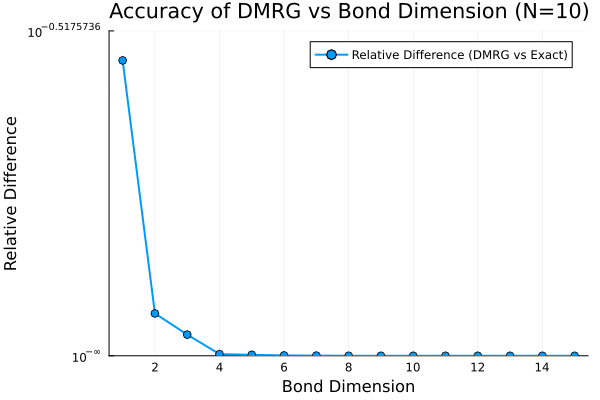

In [38]:
using Plots

N=10
J=1.0
Δ=1.5

bond_dim_range = 1:1:15
dmrg_energies = Float64[]
exact_energies = Float64[]
relative_differences = Float64[]

# Generate adjacency matrix once outside the loop
adj_mat = generate_chain_adjacency_matrix(N)

for b in bond_dim_range
    Χ = b
    ψ0_chain, sites_chain = create_MPS(N, Χ)
    H_chain = create_xxz_hamiltonian_mpo(N, adj_mat, J, Δ, sites_chain)
    # Pass Χ as the bond_dim parameter to DMRG solver
    ground_state_dmrg, ψ_chain_dmrg = solve_xxz_hamiltonian_dmrg(H_chain, ψ0_chain, 10, Χ)
    push!(dmrg_energies, ground_state_dmrg)
    
    h_chain = get_xxz_hamiltonian_exact(N, J, Δ)
    eigens_chain_exact, ground_state_exact, ψ_chain_exact = solve_xxz_hamiltonian_exact(h_chain)
    push!(exact_energies, ground_state_exact)
    
    rel_diff = abs((ground_state_dmrg - ground_state_exact) / ground_state_exact)
    push!(relative_differences, rel_diff)
end

println(relative_differences)

# Plot with log scale for y-axis to better see the differences
plot(bond_dim_range, relative_differences, 
    label="Relative Difference (DMRG vs Exact)",
     xlabel="Bond Dimension", 
     ylabel="Relative Difference", 
     title="Accuracy of DMRG vs Bond Dimension (N=$N)",
     yscale=:log10,
     marker=:o,
     linewidth=2,
     markersize=4,  
     ylims=(0, maximum(relative_differences)*1.1))  

We can plot a graph of DMRG_time/exact_time for increasing N. We wouldm

In [ ]:
using Plots

# We can plot a graph of DMRG_time/exact_time for increasing N.
# want to do this on a logarithmic scale for the y-axis
function plot_dmrg_vs_exact_time(N_values, dmrg_times, exact_times; save_fig::Bool=false)
    """
    Plot the ratio of DMRG time to exact diagonalisation time for increasing N.
    """
    relative_times = dmrg_times ./ exact_times
    # plot a straight line at y=1 for reference
    plot(N_values, relative_times, marker=:o, xlabel="Number of Sites (N)", ylabel="DMRG Time / Exact Time", title="DMRG vs Exact Diagonalisation Time", label=nothing, yscale=:log10)
    plot!([minimum(N_values), maximum(N_values)],[1, 1], linestyle=:dash, color=:red, label="DMRG time = Exact time")

    if save_fig
        png("dmrg_vs_exact_time.png")
    end
end

plot_dmrg_vs_exact_time (generic function with 1 method)

In [37]:
# we need to generate data for increasing N

N_values = 2:12
dmrg_times = Float64[]
exact_times = Float64[]

Χ = 1000 # bond dimension
J = 1.0 # coupling constant
Δ = 1.5 # anisotropy parameter
sweeps = 10 # number of DMRG sweeps

for N in N_values

    adj_mat = generate_chain_adjacency_matrix(N)
    ψ0_chain, sites_chain = create_MPS(N, Χ)
    H_chain = create_xxz_hamiltonian_mpo(N, adj_mat, J, Δ, sites_chain)
    dmrg_time = @elapsed ground_state_dmrg, ψ_chain_dmrg = solve_xxz_hamiltonian_dmrg(H_chain, ψ0_chain, sweeps)

    exact_hamiltonian = get_xxz_hamiltonian_exact(N, J, Δ)
    exact_time = @elapsed eigens_chain_exact, ground_state_exact, ψ_chain_exact = solve_xxz_hamiltonian_exact(exact_hamiltonian)

    push!(dmrg_times, dmrg_time)
    push!(exact_times, exact_time)

    println("   N=$N: DMRG time = $dmrg_time s, Exact time = $exact_time s, Speedup = $(exact_time/dmrg_time)x")

    if abs(ground_state_exact - ground_state_dmrg) > 1E-10
        println("Warning: Significant difference (>1E-10) between DMRG and exact ground states for N=$N")
    end

end

first_dmrg_faster = nothing
for i in N_values
    if dmrg_times[i-1] < exact_times[i-1]
        first_dmrg_faster = i
        break
    end
end

print("\n")

println("DMRG becomes faster than exact diagonalisation at N=$first_dmrg_faster")

plot_dmrg_vs_exact_time(N_values, dmrg_times, exact_times; save_fig=true)


   N=2: DMRG time = 0.00450525 s, Exact time = 2.825e-5 s, Speedup = 0.006270462238499528x
   N=3: DMRG time = 0.007794792 s, Exact time = 2.3334e-5 s, Speedup = 0.0029935372233152596x
   N=4: DMRG time = 0.018152917 s, Exact time = 4.6417e-5 s, Speedup = 0.00255699951693714x
   N=5: DMRG time = 0.028735459 s, Exact time = 0.000181958 s, Speedup = 0.006332176562761708x
   N=6: DMRG time = 0.043952208 s, Exact time = 0.000626792 s, Speedup = 0.014260762508222568x
   N=7: DMRG time = 0.141893625 s, Exact time = 0.004183083 s, Speedup = 0.029480415346355412x
   N=8: DMRG time = 0.237006334 s, Exact time = 0.016042292 s, Speedup = 0.06768718679054374x
   N=9: DMRG time = 0.096722125 s, Exact time = 0.08386 s, Speedup = 0.867019826125615x
   N=10: DMRG time = 0.144619084 s, Exact time = 0.350965291 s, Speedup = 2.426825570268444x
   N=11: DMRG time = 0.199727167 s, Exact time = 1.752593125 s, Speedup = 8.774936085685328x
   N=12: DMRG time = 0.390464125 s, Exact time = 8.739316209 s, Speedu

"/Users/jamesneville-rolfe/Library/CloudStorage/GoogleDrive-james.nevillerolfe@gmail.com/My Drive/Documents/University/fourth_year/MSci-Project/Preliminaries/dmrg_vs_exact_time.png"

We can see that for roughly $N<10$, DMRG is actually slower, presumably because of overhead. 

We can see after this, we get a roughly linear line. Hence:

$$\log \frac{t_{\text{DMRG}}}{t_{\text{exact}}} = -m N \implies t_\text{DMRG} \propto t_{\text{exact}} 10^{-N} \quad \text{for} \: N\geq10$$

i.e. an exponential speedup. 

In [14]:
# convert DMRG wavefunction from MPS format to a regular array
function mps_to_array(ψ::MPS)
    """
    Convert an MPS wavefunction to a full state vector (array) with correct basis ordering.
    """
    N = length(ψ)
    
    # contract the MPS to get full tensor
    ψ_tensor = ITensors.contract(ψ)
    # convert to array - this gives the correct ITensor ordering
    ψ_array = array(ψ_tensor)
    
    # reshape to vector
    ψ_vector = reshape(ψ_array, (2^N,))
    
    # Convert ITensor basis ordering to standard Kronecker product ordering
    # ITensor uses reverse ordering compared to standard tensor products
    ψ_corrected = zeros(ComplexF64, 2^N)
    
    for i in 0:(2^N-1)
        # convert index to binary representation
        binary_rep = digits(i, base=2, pad=N)
        
        # ITensor uses reverse site ordering, so flip the binary representation
        itensor_idx = 0
        for j in 1:N
            itensor_idx += binary_rep[N+1-j] * 2^(j-1)
        end
        
        ψ_corrected[i+1] = ψ_vector[itensor_idx+1]
    end
    
    return ψ_corrected
end

mps_to_array (generic function with 1 method)

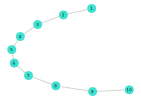

Ground state energy from DMRG (chain): -5.007453912006297
Ground state energy from exact diagonalisation: -5.0074539120062935

Overlap between DMRG and exact ground states: 1.0000000000000013
    Difference from perfect overlap: -1.3322676295501878e-15
Normalization of DMRG wavefunction: 1.0000000000000009
    Difference from perfect normalization: -8.881784197001252e-16


In [39]:
# let's do this again, and compare to the exact diagonalisation result
N = 10
Χ = 1000 # bond dimension
J = 1.0 # coupling constant
Δ = 1.5 # anisotropy parameter

# DMRG
adj_mat = generate_chain_adjacency_matrix(N)
plot_adjacency_matrix(adj_mat; layout_type="spring")
ψ0_chain, sites_chain = create_MPS(N, Χ)
H_chain = create_xxz_hamiltonian_mpo(N, adj_mat, J, Δ, sites_chain)
ground_state_dmrg, ψ_chain_dmrg = solve_xxz_hamiltonian_dmrg(H_chain, ψ0_chain, sweeps)
println("Ground state energy from DMRG (chain): $ground_state_dmrg")

# exact diagonalisation
test_hamiltonian = get_xxz_hamiltonian_exact(N, J, Δ)
eigens_exact, ground_state_exact, ψ_chain_exact = solve_xxz_hamiltonian_exact(test_hamiltonian)
println("Ground state energy from exact diagonalisation: $ground_state_exact")
print("\n")

# convert the MPS to an array so we can compare
ψ_array = mps_to_array(ψ_chain_dmrg)

# now we can compare the two wavefunctions
overlap = abs(dot(conj(ψ_array), ψ_chain_exact))^2
println("Overlap between DMRG and exact ground states: $overlap")
println("    Difference from perfect overlap: $(1 - overlap)")
# should be very close to 1, on the order of 1E-10 or less

# we can also check the normalization of the DMRG wavefunction
norm_ψ = norm(ψ_array)^2
println("Normalization of DMRG wavefunction: $norm_ψ")
println("    Difference from perfect normalization: $(1 - norm_ψ)")

In [16]:
most_likely_state_index = argmax(abs.(ψ_array))
most_likely_state = bitstring(most_likely_state_index - 1)[end-N+1:end] # get last N bits

println("Most likely state:")
println("    Spin Configuration: $most_likely_state")
println("    Probability: $(abs(ψ_array[most_likely_state_index])^2)")

UndefVarError: UndefVarError: `ψ_array` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

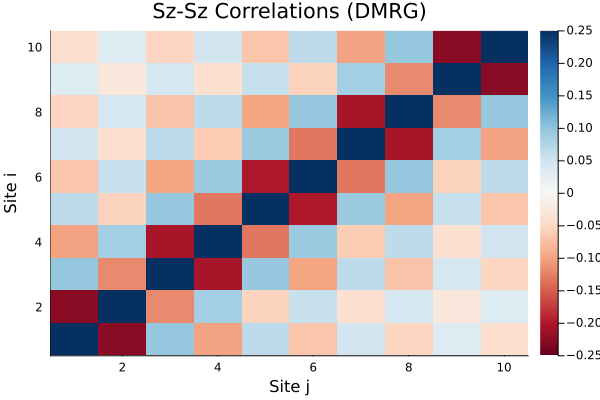

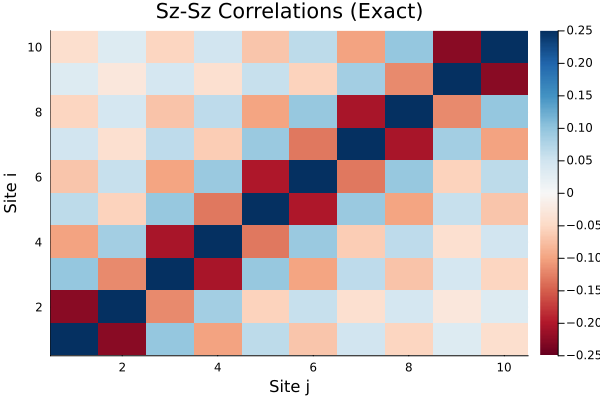

10×10 Matrix{Float64}:
  0.25       -0.22756     0.0973687  …  -0.0546031   0.0342754  -0.0423556
 -0.22756     0.25       -0.119664       0.0443352  -0.0278887   0.0342754
  0.0973687  -0.119664    0.25          -0.072008    0.0443352  -0.0546031
 -0.101272    0.0863906  -0.206695       0.065127   -0.0404522   0.0489343
  0.0657316  -0.0573363   0.0961211     -0.0999816   0.0579006  -0.0705188
 -0.0705188   0.0579006  -0.0999816  …   0.0961211  -0.0573363   0.0657316
  0.0489343  -0.0404522   0.065127      -0.206695    0.0863906  -0.101272
 -0.0546031   0.0443352  -0.072008       0.25       -0.119664    0.0973687
  0.0342754  -0.0278887   0.0443352     -0.119664    0.25       -0.22756
 -0.0423556   0.0342754  -0.0546031      0.0973687  -0.22756     0.25

In [30]:
function calculate_correlations_dmrg(ψ::MPS, sites, range=(-0.25, 0.25); save_fig::Bool=false)
    """
    Calculate spin-spin correlations using correlation_matrix function.
    """
    N = length(ψ)
    
    # Calculate <Sz_i Sz_j> correlations using built-in function
    sz_correlations = correlation_matrix(ψ, "Sz", "Sz")
    
    display(heatmap(sz_correlations, 
            xlabel="Site j", ylabel="Site i",
            title="Sz-Sz Correlations (DMRG)",
            color=:RdBu, clims=range))

    if save_fig
        png("sz_sz_correlations_dmrg.png")
    end
    
    return sz_correlations
end

function calculate_correlations_exact(ψ::Vector{ComplexF64}, range=(-0.25, 0.25); save_fig::Bool=false)
    """
    Calculate spin-spin correlations <Sz_i Sz_j> from the full wavefunction array.
    """
    N = Int(log2(length(ψ))) # number of sites
    sz_correlations = zeros(Float64, N, N)
    
    # Define Sz operator for a single spin-1/2 site
    sz = 0.5 * [1.0 0.0; 0.0 -1.0]
    
    sz_ops = Vector{Matrix{ComplexF64}}(undef, N)
    for i in 1:N
        op = 1.0 # start with placeholder, will be built
        for j in 1:N
            if j == i
                op = kron(op, sz)
            else
                op = kron(op, I(2))
            end
        end
        sz_ops[i] = op
    end

    # calc correlations using <ψ|Sz_i Sz_j|ψ> via matrix multiplication
    for i in 1:N
        for j in 1:N
            if i == j
                # Diagonal: <Sz_i^2> = <ψ|Sz_i * Sz_i|ψ>
                sz_correlations[i, j] = real(ψ' * (sz_ops[i] * sz_ops[i] * ψ))
            else
                # Off-diagonal: <Sz_i * Sz_j> = <ψ|Sz_i * Sz_j|ψ>
                sz_correlations[i, j] = real(ψ' * (sz_ops[i] * sz_ops[j] * ψ))
            end
        end
    end
    
    display(heatmap(sz_correlations, 
            xlabel="Site j", ylabel="Site i",
            title="Sz-Sz Correlations (Exact)",
            color=:RdBu, clims=range))

    if save_fig
        png("sz_sz_correlations_exact.png")
    end

    return sz_correlations
end

correlations_dmrg = calculate_correlations_dmrg(ψ_chain_dmrg, sites_chain; save_fig=true)
correlations_exact = calculate_correlations_exact(ψ_chain_exact; save_fig=true)


Here we can see the antiferromagnetism occuring - spins next to each other are anticorrelated strongly, implying that they should point opposite to each other. The correlation strength decreases as we go down the chain.

We also have open boundary conditions here, and so for the relatively small N that we are using here, we see edge effects (or finite size effects) appearing.

In [18]:
using Statistics

println("\n3D plot of Sz-Sz correlations between all pairs of sites:")
N_sites = size(correlations_dmrg, 1)
x = 1:N_sites
y = 1:N_sites
surface(x, y, correlations_dmrg;
    xlabel="Site i",
    ylabel="Site j",
    zlabel="Sz-Sz Correlation",
    title="3D Sz-Sz Correlation Matrix",
    color=:RdBu,
    clims=(-0.25, 0.25)
)



3D plot of Sz-Sz correlations between all pairs of sites:


UndefVarError: UndefVarError: `correlations_dmrg` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

# NOTE: DMRG limitations on initial condition

I discovered what the initial state does in the create_MPS function. It essentially allocates the subspace of states that we are allowed to explore. So here it is set to 'up dn up dn ...'. This means that it can explore all the states where the total magnetisation is zero. However, when I went to set J=-1, which should give rise to ferromagnetic states, it actually couldn't find them (and hence settled eventually on 00001111 for N=8 - which isn't purely ferromagnetic, but is about as good as it can get for total magnetisation = 0). This is why for negative J, DMRG here doesn't match exact diagonalisation at all - we would have to set a different initail state to conserve.

The point in the conservation is speed - it drastically reduces our computation time. A lot of the time, it can be proven that the ground state should have zero net magnetisation (or some other value), and so this assumption is reasonable.

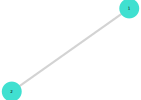

Ground state energy from DMRG (chain) with conservation of total Sz: -0.12499999999999999
Ground state energy from DMRG (chain) without conservation of total Sz: -0.12499999999999999


In [19]:
# we can test this proposition
# for N=2, J=-1, Δ=1.5, the groundstate should be the ferromagnetic state |↑↑> or |↓↓> with energy -0.375

N = 2
Χ = 1000 # bond dimension
J = -1.0 # coupling constant (negative for ferromagnetic)
Δ = 1.5 # anisotropy parameter

# with conserving qns (i.e. total Sz)
adj_mat = generate_chain_adjacency_matrix(N)
plot_adjacency_matrix(adj_mat; layout_type="circular")
ψ0_chain_conserved, sites_chain_conserved = create_MPS(N, Χ; conserve_qns=true) # conserve total Sz = 0 subspace
H_chain = create_xxz_hamiltonian_mpo(N, adj_mat, J, Δ, sites_chain_conserved)
E_chain, ψ_chain = solve_xxz_hamiltonian_dmrg(H_chain, ψ0_chain_conserved, sweeps)
println("Ground state energy from DMRG (chain) with conservation of total Sz: $E_chain")

# without conserving qns (i.e. total Sz)
ψ0_chain_unconserved, sites_chain_unconserved = create_MPS(N, Χ; conserve_qns=false) # do not conserve total Sz
H_chain_unconserved = create_xxz_hamiltonian_mpo(N, adj_mat, J, Δ, sites_chain_unconserved)
E_chain_unconserved, ψ_chain_unconserved = solve_xxz_hamiltonian_dmrg(H_chain_unconserved, ψ0_chain_unconserved, sweeps)
println("Ground state energy from DMRG (chain) without conservation of total Sz: $E_chain_unconserved")

The reason this still doesn't work is because DMRG is a local optimisation algorithm - and so since we are still starting in the antiferromagnetic state, we are still falling into that as the ground state. Let's redefine the createMPS function to take in an initial state.

In [20]:
function create_custom_MPS(L::Int, Χ::Int, init_state::Vector{String}; conserve_qns::Bool=true)
    """Create a random MPS for a spin-1/2 chain of length L with bond dimension Χ and a custom initial state."""
    # create a site set for a spin-1/2 chain
    sites = siteinds("S=1/2", L; conserve_qns=conserve_qns) # conserve total Sz

    # create a random MPS with bond dimension Χ
    ψ0 = randomMPS(sites, init_state)
    return ψ0, sites
end

create_custom_MPS (generic function with 1 method)

In [21]:
# now lets try this again

# create random string of "Up" and "Dn" of length N
function random_spin_configuration(N::Int, p_dn::Float64=0.5)
    """Genererate a random spin configuration of length N with probability p_dn of "Dn"."""
    return [rand() < p_dn ? "Dn" : "Up" for _ in 1:N]
end

init_state = random_spin_configuration(N, 0.5)
println("Initial state: $init_state")
ψ0_chain_custom, sites_chain_custom = create_custom_MPS(N, Χ, init_state; conserve_qns=false) # do not conserve total Sz
H_chain_custom = create_xxz_hamiltonian_mpo(N, adj_mat, J, Δ, sites_chain_custom)
E_chain_custom, ψ_chain_custom = solve_xxz_hamiltonian_dmrg(H_chain_custom, ψ0_chain_custom, sweeps)
println("Ground state energy from DMRG (chain) with custom initial state: $E_chain_custom")

Initial state: ["Dn", "Dn"]
Ground state energy from DMRG (chain) with custom initial state: -0.375


From the random state, if we get one that starts ferromagnetic i.e. ["Dn", "Dn"] we end up with the correct ground state energy with J=-1.0. So it is very sensitive to the initial state. DMRG requires initial knowledge about the system.

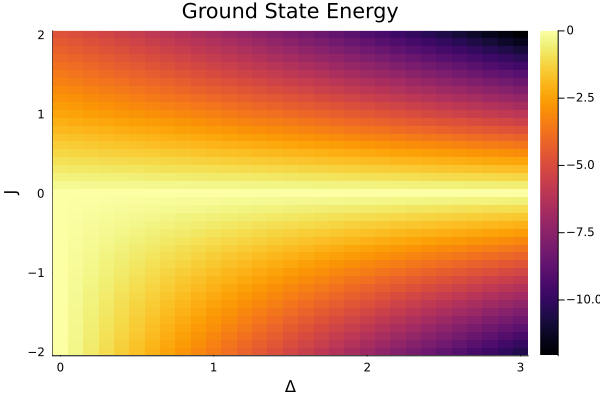

41×31 Matrix{Float64}:
  0.0      -0.35     -0.7      -1.05     …   -9.8      -10.15     -10.5
  0.0      -0.3325   -0.665    -0.9975       -9.31      -9.6425    -9.975
  0.0      -0.315    -0.63     -0.945        -8.82      -9.135     -9.45
  0.0      -0.2975   -0.595    -0.8925       -8.33      -8.6275    -8.925
  0.0      -0.28     -0.56     -0.84         -7.84      -8.12      -8.4
  0.0      -0.2625   -0.525    -0.7875   …   -7.35      -7.6125    -7.875
  0.0      -0.245    -0.49     -0.735        -6.86      -7.105     -7.35
  0.0      -0.2275   -0.455    -0.6825       -6.37      -6.5975    -6.825
  0.0      -0.21     -0.42     -0.63         -5.88      -6.09      -6.3
  0.0      -0.1925   -0.385    -0.5775       -5.39      -5.5825    -5.775
  ⋮                                      ⋱                          ⋮
 -2.85526  -2.95936  -3.06723  -3.1787       -6.88762   -7.06531   -7.2446
 -3.0932   -3.20597  -3.32283  -3.44359      -7.46158   -7.65408   -7.84832
 -3.33114  -3.45259  -3.

In [22]:
function phase_diagram_J_Δ_dmrg(N::Int, J_range, Δ_range; save_fig::Bool=false)
    
    energies = zeros(length(J_range), length(Δ_range))
    
    adj_mat = generate_chain_adjacency_matrix(N)
    
    for (i, J) in enumerate(J_range)
        for (j, Δ) in enumerate(Δ_range)
            if J < 0 # ferromagnetic, need to give a different initial state
                init_state = ["Up" for _ in 1:N] # ferromagnetic state
            else
                init_state = [isodd(k) ? "Up" : "Dn" for k = 1:N] # antiferromagnetic state
            end
            ψ0, sites = create_custom_MPS(N, 100, init_state; conserve_qns=false)
            H = create_xxz_hamiltonian_mpo(N, adj_mat, J, Δ, sites)
            E, ψ = solve_xxz_hamiltonian_dmrg(H, ψ0, 5)
            
            energies[i, j] = E
        end
    end
    
    # Plot phase diagram
    h = heatmap(Δ_range, J_range, energies, 
           xlabel="Δ", ylabel="J", 
           title="Ground State Energy")

    display(h)
    
    if save_fig
        savefig(h, "phase_diagram_J_Δ_N$(N).png")
    end

    return energies
end

J_range = -2.0:0.1:2.0
Δ_range = 0.0:0.1:3.0
energies, mags = phase_diagram_J_Δ_dmrg(8, J_range, Δ_range)

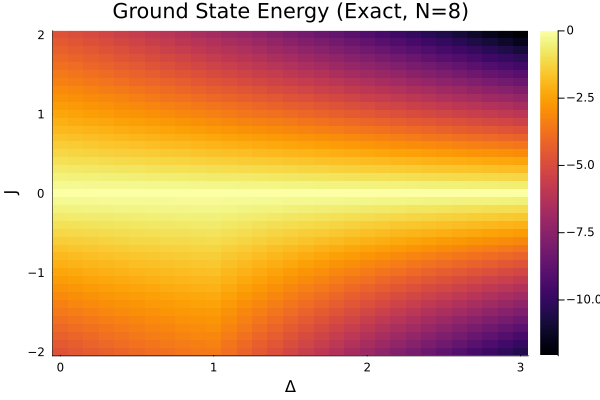

41×31 Matrix{Float64}:
 -4.75877  -4.59187  -4.43195  -4.27945  …   -9.8      -10.15     -10.5
 -4.52083  -4.36228  -4.21035  -4.06548      -9.31      -9.6425    -9.975
 -4.28289  -4.13269  -3.98876  -3.85151      -8.82      -9.135     -9.45
 -4.04495  -3.90309  -3.76716  -3.63753      -8.33      -8.6275    -8.925
 -3.80702  -3.6735   -3.54556  -3.42356      -7.84      -8.12      -8.4
 -3.56908  -3.44391  -3.32396  -3.20959  …   -7.35      -7.6125    -7.875
 -3.33114  -3.21431  -3.10237  -2.99562      -6.86      -7.105     -7.35
 -3.0932   -2.98472  -2.88077  -2.78164      -6.37      -6.5975    -6.825
 -2.85526  -2.75512  -2.65917  -2.56767      -5.88      -6.09      -6.3
 -2.61732  -2.52553  -2.43757  -2.3537       -5.39      -5.5825    -5.775
  ⋮                                      ⋱                          ⋮
 -2.85526  -2.95936  -3.06723  -3.1787       -6.88762   -7.06531   -7.2446
 -3.0932   -3.20597  -3.32283  -3.44359      -7.46158   -7.65408   -7.84832
 -3.33114  -3.45259  -3.

In [ ]:
function phase_diagram_J_Δ_exact(N::Int, J_range, Δ_range; save_fig::Bool=false)
    """
    Generate phase diagram using exact diagonalization for XXZ model.
    Returns ground state energies for all combinations of J and Δ.
    """
    
    energies = zeros(length(J_range), length(Δ_range))
    
    for (i, J) in enumerate(J_range)
        for (j, Δ) in enumerate(Δ_range)
            # Create Hamiltonian for this (J, Δ) combination
            H = get_xxz_hamiltonian_exact(N, J, Δ)
            
            # Solve for ground state
            eigens, ground_state_energy, ψ = solve_xxz_hamiltonian_exact(H)
            energies[i, j] = ground_state_energy

        end
    end
    
    # Create phase diagram plot
    p = heatmap(Δ_range, J_range, energies, 
               xlabel="Δ", ylabel="J", 
               title="Ground State Energy (Exact, N=$N)",
               aspect_ratio=:auto)
    
    display(p)
    
    if save_fig
        savefig(p, "phase_diagram_exact_N$(N).png")
    end
    
    return energies
end

N = 8 # Keep small for exact diagonalization
J_range = -2.0:0.1:2.0  # Coarser grid to reduce computation time
Δ_range = 0.0:0.1:3.0

energies_exact = phase_diagram_J_Δ_exact(N, J_range, Δ_range; save_fig=true)

## Can we measure if the state should be ferromagnetic or antiferromagnetic - or something else?

If we use the exact hamiltonian diagonalisation, can we figure out if a state is ferromagnetic or antiferromagnetic? 

We can first look at net magnetisation of the ground state on the phase space of $J$ and $\Delta$. 

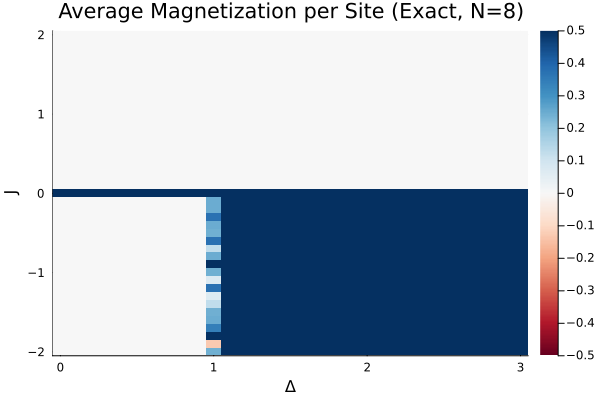

41×31 Matrix{Float64}:
 -1.52805e-18   2.46656e-18  -8.67362e-19  …   0.5           0.5
  4.46556e-18  -8.94467e-19  -9.75782e-19      0.5           0.5
  2.51399e-18   5.12286e-18   3.1984e-18       0.5           0.5
 -2.42251e-18   5.96311e-18   4.06576e-18      0.5           0.5
 -6.04443e-18   2.92735e-18   5.09575e-18      0.5           0.5
  1.17907e-18   1.00289e-18   5.42101e-20  …   0.5           0.5
 -1.38913e-18  -2.71051e-20  -1.30104e-18      0.5           0.5
  3.65241e-18  -8.67362e-19   1.13841e-17      0.5           0.5
  7.57586e-18  -7.31836e-19   2.71051e-19      0.5           0.5
  6.74238e-19  -7.04731e-18   2.49366e-18      0.5           0.5
  ⋮                                        ⋱                 ⋮
  5.19739e-18   2.98156e-18  -1.0842e-18       6.93889e-18   6.93889e-18
 -1.84992e-18  -2.30393e-18   1.35525e-18      0.0          -1.04083e-17
  2.37847e-18  -5.06865e-18  -1.57209e-18      3.46945e-18  -1.04083e-17
 -2.91379e-18  -4.60786e-18  -3.1984e-18   … 

In [24]:
function phase_space_magnetisation_J_Δ_exact(N, J_range, Δ_range; save_fig::Bool=false)
    magnetizations = zeros(length(J_range), length(Δ_range))

    for (i, J) in enumerate(J_range)
        for (j, Δ) in enumerate(Δ_range)
            H = get_xxz_hamiltonian_exact(N, J, Δ)
            eigens, ground_state_energy, ψ = solve_xxz_hamiltonian_exact(H)

            # Calculate total magnetization using <ψ|Sz_total|ψ>
            total_magnetization = 0.0
            
            # Create total Sz operator: sum of Sz_i over all sites
            sz = 0.5 * [1.0 0.0; 0.0 -1.0]
            
            for site in 1:N
                # Build Sz operator for site i
                sz_i = 1.0
                for k in 1:N
                    if k == site
                        sz_i = kron(sz_i, sz)
                    else
                        sz_i = kron(sz_i, I(2))
                    end
                end
                
                # Add expectation value <ψ|Sz_i|ψ>
                total_magnetization += real(ψ' * sz_i * ψ)
            end
            
            # Average magnetization per site
            magnetizations[i, j] = total_magnetization / N
        end
    end

    p = heatmap(Δ_range, J_range, magnetizations,
            xlabel="Δ", ylabel="J",
            title="Average Magnetization per Site (Exact, N=$N)",
            color=:RdBu,
            clims=(-0.5, 0.5),
            aspect_ratio=:auto)
    
    display(p)
    
    if save_fig
        savefig(p, "magnetization_phase_diagram_N$(N).png")
    end
    
    return magnetizations
end

N = 8 
J_range = -2.0:0.1:2.0  # Coar
Δ_range = 0.0:0.1:3.0
magnetizations_exact = phase_space_magnetisation_J_Δ_exact(N, J_range, Δ_range; save_fig=true)